In [13]:
import os
import sys
import glob
from collections import defaultdict, Counter
from functools import reduce, partial
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cosine, euclidean
from Bio import SeqIO
from ete3 import PhyloTree
import tqdm

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary, calculate_mutspec
from pymutspec.io import read_rates, GenesStates
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.annotation import get_farthest_leaf

from utils import (complete_sbs192_columns, calc_edgewise_spectra, 
                   collapse_sbs192, get_cossim, get_eucdist, calc_phylocoefs)

%matplotlib inline

In [3]:
coda = CodonAnnotation(2)

## Random species trees

### 12  all sites

In [77]:
nmuttypes = 12
param_rates = "_all_positions"

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

100%|██████████| 800/800 [00:20<00:00, 39.01it/s]


In [78]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = _df.MutSpec_rec.unstack().fillna(0.)
spectra_gt_wide = _df.MutSpec_gt.unstack().fillna(0.)

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [79]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999987,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999428,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.999980,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.999834,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999983,12.12_1000_cytb


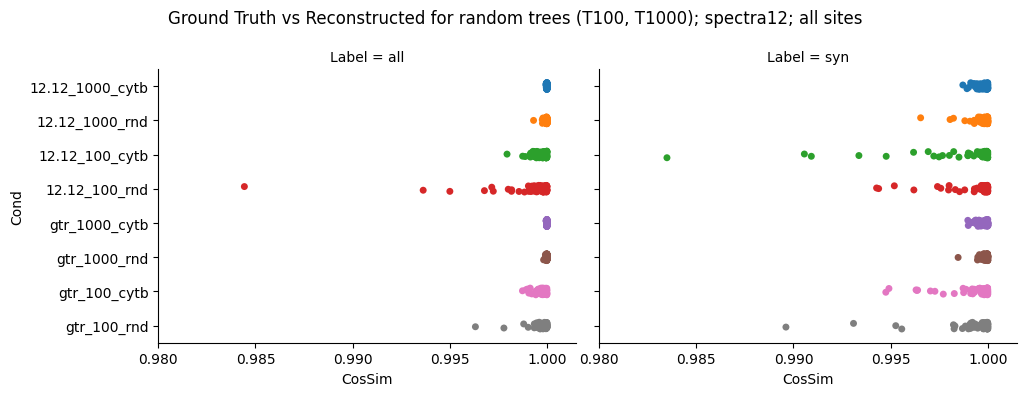

In [80]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.3);
g.fig.suptitle(f"Ground Truth vs Reconstructed for random trees (T100, T1000); spectra{nmuttypes}; all sites")
g.fig.subplots_adjust(top=0.83)
plt.xlim(0.98, 1.0015)
plt.xticks(np.linspace(0.98, 1, 5))
g.savefig(f"../figures/alisim/cossim_all_sites{nmuttypes}.pdf")
plt.show()

### 12 excluding inv sites

In [36]:
#check AltPhylocoef impact

data  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp/*")):
    elabel = d.split("/")[-1]
    # path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    rec_obs = pd.read_csv(os.path.join(d, "mutspec_tables/observed_mutations_iqtree.tsv"), sep='\t')
    rec_exp = pd.read_csv(os.path.join(d, "mutspec_tables/mean_expexted_mutations_iqtree.tsv"), sep='\t')
    tree = PhyloTree(os.path.join(d, "IQTREE/iqtree_anc_tree.nwk"), format=1)
    phylocoefs = calc_phylocoefs(tree)

    # update 'ProbaFull' for OBS 
    rec_obs['RefPhylocoef'] = rec_obs['ProbaFull'] / rec_obs['ProbaMut']
    rec_obs['RefPhylocoefTrue'] = rec_obs.RefNode.map(phylocoefs).astype(np.float32)
    assert np.allclose(rec_obs.RefPhylocoef.values, rec_obs.RefPhylocoefTrue.values)

    rec_obs['AltPhylocoefTrue'] = rec_obs.AltNode.map(phylocoefs).astype(np.float32)

    rec_obs['ProbaNotFull'] = rec_obs['ProbaFull']
    rec_obs['ProbaFull'] *= rec_obs['AltPhylocoefTrue']

    data.append((rec_obs.ProbaNotFull - rec_obs.ProbaFull).rename('diff').to_frame().assign(Replic=elabel))

100%|██████████| 800/800 [01:15<00:00, 10.53it/s]


In [44]:
df = pd.concat(data, ignore_index=True)
df['mdl'] = df.Replic.apply(lambda x: x.split('_')[0])
df['tree'] = df.Replic.apply(lambda x: x.split('_')[1])
df['replic'] = df.Replic.apply(lambda x: x.split('_')[-1]).astype(int)
df

,diff,Replic,mdl,tree,replic
0,0.021301,12.12_1000_rnd_replica_77,12.12,1000,77
1,0.086848,12.12_1000_rnd_replica_77,12.12,1000,77
2,0.000000,12.12_1000_rnd_replica_77,12.12,1000,77
3,0.000018,12.12_1000_rnd_replica_77,12.12,1000,77
4,0.000018,12.12_1000_rnd_replica_77,12.12,1000,77
...,...,...,...,...,...
1051309,0.019253,12.12_1000_rnd_replica_26,12.12,1000,26
1051310,0.019258,12.12_1000_rnd_replica_26,12.12,1000,26
1051311,0.000000,12.12_1000_rnd_replica_26,12.12,1000,26
1051312,0.000000,12.12_1000_rnd_replica_26,12.12,1000,26


In [52]:
df['diff'].describe().round(3)

count    1051314.000
mean           0.007
std            0.015
min            0.000
25%            0.000
50%            0.000
75%            0.000
max            0.214
Name: diff, dtype: float64

In [58]:
df['diff'].quantile([.05, .75, .85, .95]).round(2)

0.05    0.00
0.75    0.00
0.85    0.02
0.95    0.04
Name: diff, dtype: float64

In [62]:
df.groupby(['mdl', 'tree', 'replic'])['diff'].mean().unstack().mean(axis=1)

mdl    tree
12.12  100     0.009731
       1000    0.006386
gtr    100     0.009970
       1000    0.006475
dtype: float64

ALtPhylocoef doesn't matter: less than 1% impact

In [81]:
nmuttypes = 12
param_rates = ""

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

  0%|          | 3/800 [00:00<00:27, 28.69it/s]

100%|██████████| 800/800 [00:20<00:00, 39.69it/s]


In [82]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = _df.MutSpec_rec.unstack().fillna(0.)
spectra_gt_wide = _df.MutSpec_gt.unstack().fillna(0.)

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [83]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999975,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999458,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.998176,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.999250,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999961,12.12_1000_cytb


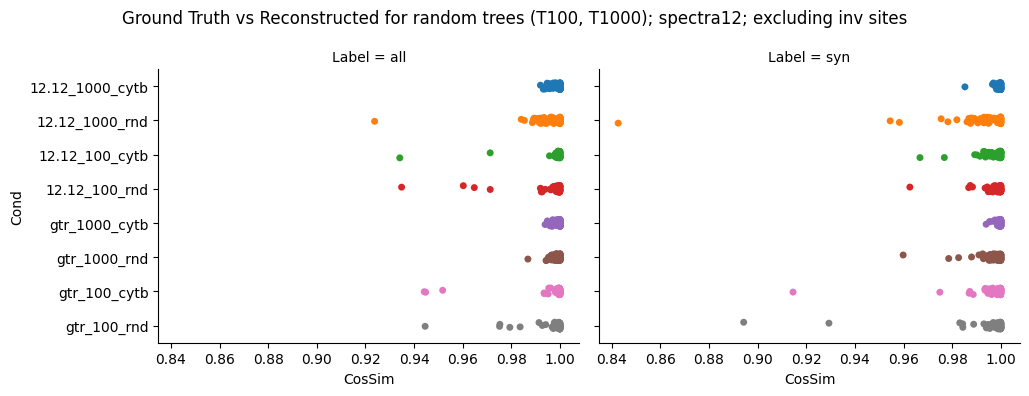

In [87]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.3);
g.fig.suptitle(f"Ground Truth vs Reconstructed for random trees (T100, T1000); spectra{nmuttypes}; excluding inv sites")
g.fig.subplots_adjust(top=0.83)
plt.xticks(np.linspace(0.84, 1, 9))
g.savefig(f"../figures/alisim/cossim_ex_cat2_sites{nmuttypes}.pdf")
plt.show()

In [88]:
cutoff = 0.95
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack().fillna(0).T

Cond          12.12_1000_cytb        12.12_1000_rnd       12.12_100_cytb  \
Label                     all    syn            all   syn            all   
cossim > 0.95                                                              
False                     0.0    0.0            1.0   1.0            1.0   
True                    100.0  100.0           99.0  99.0           99.0   

Cond                 12.12_100_rnd        gtr_1000_cytb        gtr_1000_rnd  \
Label            syn           all    syn           all    syn          all   
cossim > 0.95                                                                 
False            0.0           1.0    0.0           0.0    0.0          0.0   
True           100.0          99.0  100.0         100.0  100.0        100.0   

Cond                 gtr_100_cytb       gtr_100_rnd        
Label            syn          all   syn         all   syn  
cossim > 0.95                                              
False            0.0          2.0   1.0         1.0   2.0  
True           100.0         98.0  99.0        99.0  98.0

### 192  all sites

In [90]:
nmuttypes = 192
param_rates = "_all_positions"

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [02:50<00:00,  4.68it/s]


In [94]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = complete_sbs192_columns(_df.MutSpec_rec.unstack().fillna(0.))
spectra_gt_wide = complete_sbs192_columns(_df.MutSpec_gt.unstack().fillna(0.))

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [95]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999597,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999602,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.999738,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.999631,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999143,12.12_1000_cytb


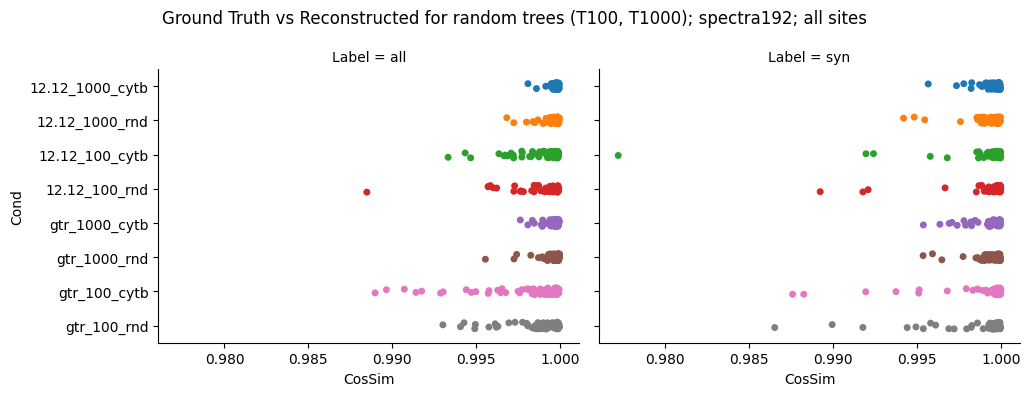

In [103]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.3);
g.fig.suptitle(f"Ground Truth vs Reconstructed for random trees (T100, T1000); spectra{nmuttypes}; all sites")
g.fig.subplots_adjust(top=0.83)
plt.xticks(np.linspace(0.98, 1, 5))
g.savefig(f"../figures/alisim/cossim_all_sites{nmuttypes}.pdf")
plt.show()

### 192 excluding inv sites

In [104]:
nmuttypes = 192
param_rates = ""

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

100%|██████████| 800/800 [03:46<00:00,  3.53it/s]


In [105]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = complete_sbs192_columns(_df.MutSpec_rec.unstack().fillna(0.))
spectra_gt_wide = complete_sbs192_columns(_df.MutSpec_gt.unstack().fillna(0.))

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [106]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999536,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999419,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.991392,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.998894,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999281,12.12_1000_cytb


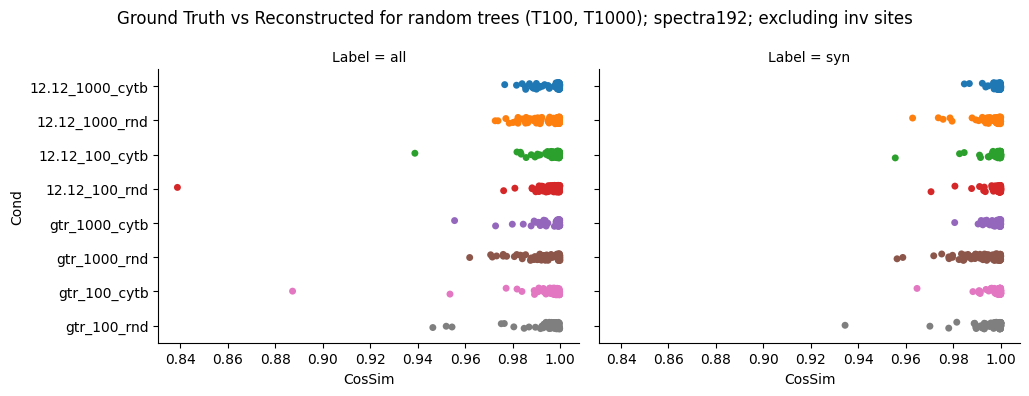

In [111]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.3);
g.fig.suptitle(f"Ground Truth vs Reconstructed for random trees (T100, T1000); spectra{nmuttypes}; excluding inv sites")
g.fig.subplots_adjust(top=0.83)
plt.xticks(np.linspace(0.84, 1, 9))
g.savefig(f"../figures/alisim/cossim_ex_cat2_sites{nmuttypes}.pdf")
plt.show()

In [108]:
cutoff = 0.95
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack().fillna(0).T

Cond          12.12_1000_cytb        12.12_1000_rnd        12.12_100_cytb  \
Label                     all    syn            all    syn            all   
cossim > 0.95                                                               
False                     0.0    0.0            0.0    0.0            1.0   
True                    100.0  100.0          100.0  100.0           99.0   

Cond                 12.12_100_rnd        gtr_1000_cytb        gtr_1000_rnd  \
Label            syn           all    syn           all    syn          all   
cossim > 0.95                                                                 
False            0.0           1.0    0.0           0.0    0.0          0.0   
True           100.0          99.0  100.0         100.0  100.0        100.0   

Cond                 gtr_100_cytb        gtr_100_rnd        
Label            syn          all    syn         all   syn  
cossim > 0.95                                               
False            0.0          1.0    0.0         1.0   1.0  
True           100.0         99.0  100.0        99.0  98.0